In [1]:
#==================================
# BLOCK 1 - Setup and Imports (same as before)
#==================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#==================================
# BLOCK 2 - Load and Extract Target Profile
#==================================
# Load the dataset
ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')

# Select two consecutive time steps
time_idx = 30  # Initial time
time_idx_target = time_idx + 100  # Target time

X_init = ds.isel(time=time_idx)
X_target = ds.isel(time=time_idx_target)

# Extract time information
dt = float((X_target.time - X_init.time) / np.timedelta64(1, 's'))
print(f"Time step size: {dt} seconds")

# Extract the probe location (middle x)
x_coords = X_init.x_caa.values
z_coords = X_init.z_aac.values
probe_idx = len(x_coords) // 2
x_probe = x_coords[probe_idx]

print(f"\nProbe location: x = {x_probe:.3f} (index {probe_idx})")

# Extract target profile data at probe location
target_profile = {
    'u': X_target['u'].isel(x_faa=probe_idx).values,  # Note: u is on x_faa grid
    'w': X_target['w'].isel(x_caa=probe_idx).values,  # w is on z_aaf grid  
    'b': X_target['b'].isel(x_caa=probe_idx).values,
    'p_dyn': X_target['p_dyn'].isel(x_caa=probe_idx).values
}

print("\nTarget profile shapes:")
for var, profile in target_profile.items():
    print(f"{var}: {profile.shape}")

Time step size: 50.0 seconds

Probe location: x = 0.004 (index 128)

Target profile shapes:
u: (256,)
w: (257,)
b: (256,)
p_dyn: (256,)


C:\Users\deban\AppData\Local\Temp\ipykernel_53120\524097938.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('../../dat/RBC_Output.nc')


In [4]:
#==================================
# BLOCK 3 - Interpolation and Profile Handling
#==================================
def interpolate_to_common_grid(field, target_shape=(256, 256)):
    if field.shape == target_shape:
        return field
    
    field_tensor = torch.from_numpy(field).float().unsqueeze(0).unsqueeze(0)
    interpolated = F.interpolate(field_tensor, size=target_shape, mode='bilinear', align_corners=True)
    return interpolated.squeeze().numpy()

# Extract initial fields
u_init = X_init['u'].values
w_init = X_init['w'].values
b_init = X_init['b'].values
p_dyn_init = X_init['p_dyn'].values

# Extract full target fields (for validation only, not used in training)
u_target_full = X_target['u'].values
w_target_full = X_target['w'].values
b_target_full = X_target['b'].values

# Interpolate all fields to common grid
u_init_interp = interpolate_to_common_grid(u_init, (256, 256))
w_init_interp = interpolate_to_common_grid(w_init, (256, 256))
u_target_interp = interpolate_to_common_grid(u_target_full, (256, 256))
w_target_interp = interpolate_to_common_grid(w_target_full, (256, 256))

# Interpolate w profile to match z_aac grid (256 points)
w_profile_interp = np.interp(z_coords, X_target.z_aaf.values, target_profile['w'])
target_profile['w'] = w_profile_interp

print("\nAfter interpolation:")
print(f"All fields and profiles now have consistent z-dimension: {len(z_coords)}")


After interpolation:
All fields and profiles now have consistent z-dimension: 256


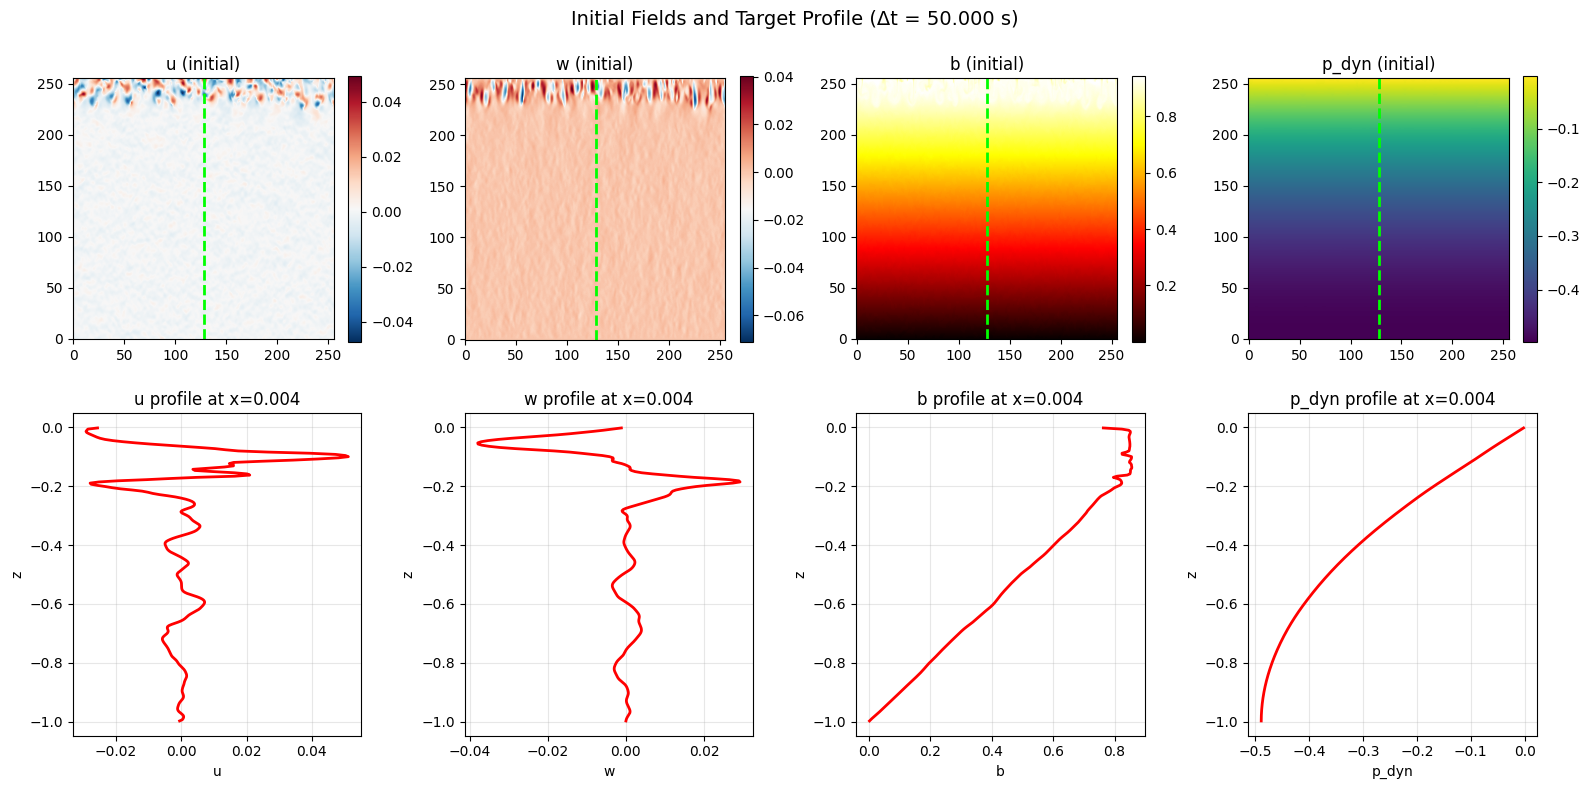

In [5]:
#==================================
# BLOCK 4 - Visualization of Initial Data and Target Profile
#==================================
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Plot initial fields
fields_init = [u_init, w_init, b_init, p_dyn_init]
titles_init = ['u (initial)', 'w (initial)', 'b (initial)', 'p_dyn (initial)']
cmaps = ['RdBu_r', 'RdBu_r', 'hot', 'viridis']

for i, (field, title, cmap) in enumerate(zip(fields_init, titles_init, cmaps)):
    im = axes[0, i].imshow(field, aspect='equal', cmap=cmap, origin='lower')
    axes[0, i].set_title(title)
    axes[0, i].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2, label='Probe')
    plt.colorbar(im, ax=axes[0, i], fraction=0.046)

# Plot target profiles
for i, var in enumerate(['u', 'w', 'b', 'p_dyn']):
    axes[1, i].plot(target_profile[var], z_coords, 'r-', linewidth=2)
    axes[1, i].set_ylabel('z')
    axes[1, i].set_xlabel(var)
    axes[1, i].set_title(f'{var} profile at x={x_probe:.3f}')
    axes[1, i].grid(True, alpha=0.3)

plt.suptitle(f'Initial Fields and Target Profile (Δt = {dt:.3f} s)', fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
#==================================
# BLOCK 5 - Normalization with Profile Handling
#==================================
def normalize_field(field):
    mean = np.mean(field)
    std = np.std(field)
    return (field - mean) / (std + 1e-8), mean, std

# Normalize initial fields
u_init_norm, u_init_mean, u_init_std = normalize_field(u_init_interp)
w_init_norm, w_init_mean, w_init_std = normalize_field(w_init_interp)
b_init_norm, b_init_mean, b_init_std = normalize_field(b_init)
p_norm, p_mean, p_std = normalize_field(p_dyn_init)

# Normalize target profiles using field statistics
target_profile_norm = {
    'u': (target_profile['u'] - u_init_mean) / (u_init_std + 1e-8),
    'w': (target_profile['w'] - w_init_mean) / (w_init_std + 1e-8),
    'b': (target_profile['b'] - b_init_mean) / (b_init_std + 1e-8),
}

# Store normalization parameters
norm_params = {
    'u': (u_init_mean, u_init_std),
    'w': (w_init_mean, w_init_std),
    'b': (b_init_mean, b_init_std),
    'p': (p_mean, p_std),
}

print("Normalization statistics:")
for field, (mean, std) in norm_params.items():
    print(f"{field}: mean={mean:.4f}, std={std:.4f}")

Normalization statistics:
u: mean=-0.0000, std=0.0045
w: mean=0.0000, std=0.0053
b: mean=0.4968, std=0.2838
p: mean=-0.3305, std=0.1489


In [7]:
#==================================
# BLOCK 6 - Enhanced Multi-Field DeepONet Architecture
#==================================
class CNNBranchNet(nn.Module):
    """8-layer CNN for processing spatial fields"""
    def __init__(self, in_channels=4, hidden_dim=64, out_dim=256):
        super(CNNBranchNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim*2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_dim*2)
        
        self.conv3 = nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_dim*2)
        
        self.conv4 = nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(hidden_dim*4)
        
        self.conv5 = nn.Conv2d(hidden_dim*4, hidden_dim*4, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(hidden_dim*4)
        
        self.conv6 = nn.Conv2d(hidden_dim*4, hidden_dim*4, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(hidden_dim*4)
        
        self.conv7 = nn.Conv2d(hidden_dim*4, hidden_dim*2, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(hidden_dim*2)
        
        self.conv8 = nn.Conv2d(hidden_dim*2, out_dim, 3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.bn4(self.conv4(x)))
        x = self.activation(self.bn5(self.conv5(x)))
        x = self.activation(self.bn6(self.conv6(x)))
        x = self.activation(self.bn7(self.conv7(x)))
        x = self.conv8(x)
        x = self.pool(x)
        return x.squeeze(-1).squeeze(-1)

class MLPTrunkNet(nn.Module):
    """8-layer MLP for processing time"""
    def __init__(self, in_dim=1, hidden_dim=64, out_dim=256):
        super(MLPTrunkNet, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.fc4 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc5 = nn.Linear(hidden_dim*4, hidden_dim*4)
        self.fc6 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc7 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc8 = nn.Linear(hidden_dim, out_dim)
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, t):
        t = self.activation(self.fc1(t))
        t = self.activation(self.fc2(t))
        t = self.dropout(t)
        t = self.activation(self.fc3(t))
        t = self.activation(self.fc4(t))
        t = self.dropout(t)
        t = self.activation(self.fc5(t))
        t = self.activation(self.fc6(t))
        t = self.activation(self.fc7(t))
        t = self.fc8(t)
        return t

class MultiFieldDeepONet(nn.Module):
    """DeepONet for predicting multiple fields (b, u, w)"""
    def __init__(self, branch_dim=256, trunk_dim=256, grid_size=256):
        super(MultiFieldDeepONet, self).__init__()
        
        self.branch_net = CNNBranchNet(in_channels=4, out_dim=branch_dim)
        self.trunk_net = MLPTrunkNet(in_dim=1, out_dim=trunk_dim)
        
        # Separate decoders for each field
        self.decoder_b = self._make_decoder(branch_dim, grid_size)
        self.decoder_u = self._make_decoder(branch_dim, grid_size)
        self.decoder_w = self._make_decoder(branch_dim, grid_size)
        self.grid_size = grid_size
        
    def _make_decoder(self, input_dim, grid_size):
        return nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 2048),
            nn.GELU(),
            nn.LayerNorm(2048),
            nn.Linear(2048, 4096),
            nn.GELU(),
            nn.Linear(4096, grid_size * grid_size)
        )
        
    def forward(self, spatial_fields, delta_t):
        # Branch network output
        branch_out = self.branch_net(spatial_fields)
        
        # Trunk network output  
        trunk_out = self.trunk_net(delta_t)
        
        # Combine via element-wise multiplication
        combined = branch_out * trunk_out
        
        # Decode to spatial fields
        b_pred = self.decoder_b(combined).view(-1, self.grid_size, self.grid_size)
        u_pred = self.decoder_u(combined).view(-1, self.grid_size, self.grid_size)
        w_pred = self.decoder_w(combined).view(-1, self.grid_size, self.grid_size)
        
        return b_pred, u_pred, w_pred

In [8]:
#==================================
# BLOCK 7 - Spatial Weighting Functions
#==================================
def create_gaussian_weights(grid_size, probe_idx, sigma, device):
    """Create 2D Gaussian weights centered at probe location"""
    x = torch.arange(grid_size, device=device)
    z = torch.arange(grid_size, device=device)
    xx, zz = torch.meshgrid(x, z, indexing='xy')
    
    # Distance from probe line (only x-distance matters for vertical line)
    dist = torch.abs(xx - probe_idx).float()
    
    # Gaussian weights
    weights = torch.exp(-0.5 * (dist / sigma)**2)
    weights = weights / weights.max()  # Normalize to [0, 1]
    
    return weights

def compute_adaptive_sigma(epoch, warmup_epochs, propagation_epochs, dx, grid_size):
    """Compute sigma for Gaussian weights based on training progress"""
    if epoch < warmup_epochs:
        # During warmup, use very narrow Gaussian
        return 2 * dx
    
    elif epoch < warmup_epochs + propagation_epochs:
        # Progressive expansion
        progress = (epoch - warmup_epochs) / propagation_epochs
        # Start narrow, expand to cover ~99% of domain at the end
        sigma_min = 2 * dx
        sigma_max = 0.5  # This gives ~99% coverage at boundaries
        sigma = sigma_min + progress * (sigma_max - sigma_min)
        return sigma
    
    else:
        # Full domain - return large sigma (effectively uniform)
        return 1000.0

In [9]:
#==================================
# BLOCK 8 - Loss Functions with Spatial Weighting
#==================================
def compute_derivatives(field, dx, dz):
    """Compute spatial derivatives using finite differences with periodic BC in x"""
    if field.dim() == 2:
        field = field.unsqueeze(0)

    # x-derivatives with periodic padding
    field_padded = F.pad(field, (1, 1, 0, 0), mode='circular')
    df_dx = (field_padded[:, :, 2:] - field_padded[:, :, :-2]) / (2 * dx)

    # z-derivatives with one-sided at boundaries
    df_dz = torch.zeros_like(field)
    df_dz[:, 1:-1, :] = (field[:, 2:, :] - field[:, :-2, :]) / (2 * dz)
    df_dz[:, 0, :] = (field[:, 1, :] - field[:, 0, :]) / dz
    df_dz[:, -1, :] = (field[:, -1, :] - field[:, -2, :]) / dz

    return df_dx, df_dz

def physics_loss_heat_equation(b_pred, u_pred, w_pred, b_init, dx, dz, dt, kappa, 
                               norm_params, spatial_weights=None):
    """Heat equation physics loss with spatial weighting"""
    # Denormalize
    b_mean, b_std = norm_params['b']
    u_mean, u_std = norm_params['u'] 
    w_mean, w_std = norm_params['w']
    
    b_pred_phys = b_pred * b_std + b_mean
    b_init_phys = b_init * b_std + b_mean
    u_pred_phys = u_pred * u_std + u_mean
    w_pred_phys = w_pred * w_std + w_mean
    
    # Derivatives
    db_dx, db_dz = compute_derivatives(b_pred_phys, dx, dz)
    d2b_dx2, _ = compute_derivatives(db_dx, dx, dz)
    _, d2b_dz2 = compute_derivatives(db_dz, dx, dz)
    
    # Time derivative
    db_dt = (b_pred_phys - b_init_phys) / dt
    
    # Advection
    advection = u_pred_phys * db_dx + w_pred_phys * db_dz
    
    # Diffusion
    diffusion = kappa * (d2b_dx2 + d2b_dz2)
    
    # Residual
    residual = db_dt + advection - diffusion
    
    if spatial_weights is not None:
        residual = residual * spatial_weights.unsqueeze(0)
        
    return torch.mean(residual**2)

def physics_loss_continuity(u_pred, w_pred, dx, dz, norm_params, spatial_weights=None):
    """Incompressibility constraint with spatial weighting"""
    # Denormalize
    u_mean, u_std = norm_params['u']
    w_mean, w_std = norm_params['w']
    
    u_pred_phys = u_pred * u_std + u_mean
    w_pred_phys = w_pred * w_std + w_mean
    
    # Derivatives
    du_dx, _ = compute_derivatives(u_pred_phys, dx, dz)
    _, dw_dz = compute_derivatives(w_pred_phys, dx, dz)
    
    # Divergence
    divergence = du_dx + dw_dz
    
    if spatial_weights is not None:
        divergence = divergence * spatial_weights.unsqueeze(0)
        
    return torch.mean(divergence**2)

def boundary_condition_loss(b_pred, u_pred, w_pred, norm_params):
    """Boundary condition losses"""
    # Denormalize
    b_mean, b_std = norm_params['b']
    b_pred_phys = b_pred * b_std + b_mean
    
    # Buoyancy BCs
    b_top_bc = torch.mean((b_pred_phys[:, -1, :] - 0.5)**2)
    b_bottom_bc = torch.mean((b_pred_phys[:, 0, :])**2)
    
    # Velocity BCs (no-slip)
    u_top_bc = torch.mean(u_pred[:, -1, :]**2)
    u_bottom_bc = torch.mean(u_pred[:, 0, :]**2)
    w_top_bc = torch.mean(w_pred[:, -1, :]**2)
    w_bottom_bc = torch.mean(w_pred[:, 0, :]**2)
    
    return b_top_bc + b_bottom_bc + u_top_bc + u_bottom_bc + w_top_bc + w_bottom_bc

def profile_loss(b_pred, u_pred, w_pred, target_profiles, probe_idx):
    """Loss for matching the known vertical profile"""
    b_profile_pred = b_pred[:, :, probe_idx]
    u_profile_pred = u_pred[:, :, probe_idx]
    w_profile_pred = w_pred[:, :, probe_idx]
    
    l_b = torch.mean((b_profile_pred - target_profiles['b'])**2)
    l_u = torch.mean((u_profile_pred - target_profiles['u'])**2)
    l_w = torch.mean((w_profile_pred - target_profiles['w'])**2)
    
    return l_b + l_u + l_w

def initial_condition_loss(b_pred, u_pred, w_pred, b_init, u_init, w_init):
    """IC loss for all fields"""
    l_b = torch.mean((b_pred - b_init)**2)
    l_u = torch.mean((u_pred - u_init)**2)
    l_w = torch.mean((w_pred - w_init)**2)
    return l_b + l_u + l_w

def smoothness_loss(b_pred, u_pred, w_pred):
    """Total variation regularization"""
    tv_b = torch.mean(torch.abs(b_pred[:, 1:, :] - b_pred[:, :-1, :])) + \
           torch.mean(torch.abs(b_pred[:, :, 1:] - b_pred[:, :, :-1]))
    tv_u = torch.mean(torch.abs(u_pred[:, 1:, :] - u_pred[:, :-1, :])) + \
           torch.mean(torch.abs(u_pred[:, :, 1:] - u_pred[:, :, :-1]))
    tv_w = torch.mean(torch.abs(w_pred[:, 1:, :] - w_pred[:, :-1, :])) + \
           torch.mean(torch.abs(w_pred[:, :, 1:] - w_pred[:, :, :-1]))
    return tv_b + tv_u + tv_w

In [10]:
#==================================
# BLOCK 9 - Data Preparation
#==================================
# Stack input fields
input_fields = np.stack([u_init_norm, w_init_norm, p_norm, b_init_norm], axis=0)
input_tensor = torch.FloatTensor(input_fields).unsqueeze(0).to(device)

# Time tensor
dt_tensor = torch.FloatTensor([[dt]]).to(device)

# Initial condition tensors
b_init_tensor = torch.FloatTensor(b_init_norm).unsqueeze(0).to(device)
u_init_tensor = torch.FloatTensor(u_init_norm).unsqueeze(0).to(device)
w_init_tensor = torch.FloatTensor(w_init_norm).unsqueeze(0).to(device)

# Target profile tensors
target_profile_tensors = {
    'b': torch.FloatTensor(target_profile_norm['b']).to(device),
    'u': torch.FloatTensor(target_profile_norm['u']).to(device),
    'w': torch.FloatTensor(target_profile_norm['w']).to(device),
}

# Grid parameters
dx = float(x_coords[1] - x_coords[0])
dz = float(z_coords[1] - z_coords[0])
kappa = 1e-6

print(f"Grid spacing: dx={dx:.6f}, dz={dz:.6f}")
print(f"Thermal diffusivity: κ={kappa}")

Grid spacing: dx=0.007812, dz=0.003906
Thermal diffusivity: κ=1e-06


In [11]:
#==================================
# BLOCK 10 - Model Initialization
#==================================
model = MultiFieldDeepONet(branch_dim=256, trunk_dim=256, grid_size=256).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

Total parameters: 836,716,416


c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
#==================================
# BLOCK 11 - Progressive Training Loop
#==================================
torch.cuda.empty_cache()

# Training parameters
n_epochs = 3000
warmup_epochs = 200
propagation_epochs = 2000
print_interval = 100

# Initial loss weights
loss_weights = {
    'physics_heat': 0.1,    # Start small, increase gradually
    'physics_cont': 0.1,    # Start small
    'bc': 50.0,            # Strong BC enforcement
    'profile': 100.0,      # Strong profile matching
    'ic': 1.0,             # Initial condition (decreases over time)
    'smooth': 5.0          # Smoothness (decreases over time)
}

# Training history
history = {
    'total_loss': [], 'physics_heat_loss': [], 'physics_cont_loss': [],
    'bc_loss': [], 'profile_loss': [], 'ic_loss': [], 'smooth_loss': []
}

# Training loop
model.train()
best_loss = float('inf')

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass - predict all fields
    b_pred, u_pred, w_pred = model(input_tensor, dt_tensor)
    
    # Compute adaptive sigma for spatial weighting
    sigma = compute_adaptive_sigma(epoch, warmup_epochs, propagation_epochs, dx, 256)
    spatial_weights = create_gaussian_weights(256, probe_idx, sigma, device)
    
    # Compute losses
    l_physics_heat = physics_loss_heat_equation(
        b_pred, u_pred, w_pred, b_init_tensor, 
        dx, dz, dt, kappa, norm_params, spatial_weights
    )
    
    l_physics_cont = physics_loss_continuity(
        u_pred, w_pred, dx, dz, norm_params, spatial_weights
    )
    
    l_bc = boundary_condition_loss(b_pred, u_pred, w_pred, norm_params)
    l_profile = profile_loss(b_pred, u_pred, w_pred, target_profile_tensors, probe_idx)
    l_ic = initial_condition_loss(b_pred, u_pred, w_pred, b_init_tensor, u_init_tensor, w_init_tensor)
    l_smooth = smoothness_loss(b_pred, u_pred, w_pred)
    
    # Adaptive weight scheduling
    if epoch < warmup_epochs:
        # During warmup, focus on IC and profile
        current_weights = {
            'physics_heat': 0.01,
            'physics_cont': 0.01,
            'bc': loss_weights['bc'],
            'profile': loss_weights['profile'],
            'ic': loss_weights['ic'],
            'smooth': loss_weights['smooth']
        }
    elif epoch < warmup_epochs + propagation_epochs:
        # Progressive propagation phase
        progress = (epoch - warmup_epochs) / propagation_epochs
        current_weights = {
            'physics_heat': loss_weights['physics_heat'] * (0.1 + 0.9 * progress),
            'physics_cont': loss_weights['physics_cont'] * (0.1 + 0.9 * progress),
            'bc': loss_weights['bc'],
            'profile': loss_weights['profile'] * (1.0 - 0.5 * progress),  # Gradually reduce
            'ic': loss_weights['ic'] * (1.0 - 0.9 * progress),  # Fade out IC
            'smooth': loss_weights['smooth'] * (1.0 - 0.8 * progress)  # Reduce smoothness
        }
    else:
        # Full domain phase
        current_weights = {
            'physics_heat': loss_weights['physics_heat'],
            'physics_cont': loss_weights['physics_cont'],
            'bc': loss_weights['bc'],
            'profile': loss_weights['profile'] * 0.5,
            'ic': loss_weights['ic'] * 0.1,
            'smooth': loss_weights['smooth'] * 0.2
        }
    
    # Total loss
    total_loss = (current_weights['physics_heat'] * l_physics_heat +
                  current_weights['physics_cont'] * l_physics_cont +
                  current_weights['bc'] * l_bc +
                  current_weights['profile'] * l_profile +
                  current_weights['ic'] * l_ic +
                  current_weights['smooth'] * l_smooth)
    
    # Backward pass
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    # Record history
    history['total_loss'].append(total_loss.item())
    history['physics_heat_loss'].append(l_physics_heat.item())
    history['physics_cont_loss'].append(l_physics_cont.item())
    history['bc_loss'].append(l_bc.item())
    history['profile_loss'].append(l_profile.item())
    history['ic_loss'].append(l_ic.item())
    history['smooth_loss'].append(l_smooth.item())
    
    # Learning rate scheduling
    if epoch > 500 and epoch % 200 == 0:
        for g in optimizer.param_groups:
            g['lr'] *= 0.95
    
    # Print progress
    if epoch % print_interval == 0 or epoch == n_epochs - 1:
        phase = "Warmup" if epoch < warmup_epochs else \
                "Propagation" if epoch < warmup_epochs + propagation_epochs else \
                "Full Domain"
        print(f"Epoch {epoch}/{n_epochs} [{phase}] σ={sigma:.3f}")
        print(f"  Total: {total_loss.item():.6f} | Heat: {l_physics_heat.item():.6f} | "
              f"Cont: {l_physics_cont.item():.6f} | BC: {l_bc.item():.6f}")
        print(f"  Profile: {l_profile.item():.6f} | IC: {l_ic.item():.6f} | "
              f"Smooth: {l_smooth.item():.6f}")
        print()

In [ ]:
#==================================
# BLOCK 12 - Training History Visualization
#==================================
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

loss_names = ['total_loss', 'physics_heat_loss', 'physics_cont_loss', 
              'bc_loss', 'profile_loss', 'ic_loss', 'smooth_loss']
loss_titles = ['Total Loss', 'Heat Equation Loss', 'Continuity Loss',
               'BC Loss', 'Profile Loss', 'IC Loss', 'Smoothness Loss']

for idx, (loss_name, title) in enumerate(zip(loss_names, loss_titles)):
    if idx < len(axes):
        ax = axes[idx]
        ax.semilogy(history[loss_name])
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        
        # Mark phase transitions
        ax.axvline(x=warmup_epochs, color='r', linestyle='--', alpha=0.5, label='End Warmup')
        ax.axvline(x=warmup_epochs + propagation_epochs, color='g', linestyle='--', 
                   alpha=0.5, label='End Propagation')
        if idx == 0:
            ax.legend()

# Sigma evolution plot
ax = axes[7]
epochs = np.arange(n_epochs)
sigmas = [compute_adaptive_sigma(e, warmup_epochs, propagation_epochs, dx, 256) 
          for e in epochs]
ax.plot(epochs, sigmas)
ax.set_xlabel('Epoch')
ax.set_ylabel('σ')
ax.set_title('Gaussian Width Evolution')
ax.grid(True, alpha=0.3)

# Hide unused subplot
axes[8].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#==================================
# BLOCK 13 - Model Evaluation and Predictions
#==================================
# Make predictions
model.eval()
with torch.no_grad():
    b_pred, u_pred, w_pred = model(input_tensor, dt_tensor)
    b_pred = b_pred.squeeze().cpu().numpy()
    u_pred = u_pred.squeeze().cpu().numpy()
    w_pred = w_pred.squeeze().cpu().numpy()

# Denormalize predictions
b_pred_denorm = b_pred * b_init_std + b_init_mean
u_pred_denorm = u_pred * u_init_std + u_init_mean
w_pred_denorm = w_pred * w_init_std + w_init_mean

print(f"Prediction shapes: b={b_pred_denorm.shape}, u={u_pred_denorm.shape}, w={w_pred_denorm.shape}")
print(f"b range: [{b_pred_denorm.min():.4f}, {b_pred_denorm.max():.4f}]")
print(f"u range: [{u_pred_denorm.min():.4f}, {u_pred_denorm.max():.4f}]")
print(f"w range: [{w_pred_denorm.min():.4f}, {w_pred_denorm.max():.4f}]")

In [ ]:
#==================================
# BLOCK 14 - Prediction vs Target Comparison
#==================================
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Row 1: Buoyancy field
vmin_b = min(b_pred_denorm.min(), b_target_full.min())
vmax_b = max(b_pred_denorm.max(), b_target_full.max())

im1 = axes[0, 0].imshow(b_pred_denorm, aspect='equal', cmap='hot', 
                        vmin=vmin_b, vmax=vmax_b, origin='lower')
axes[0, 0].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[0, 0].set_title('b Prediction', fontsize=14)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(b_target_full, aspect='equal', cmap='hot', 
                        vmin=vmin_b, vmax=vmax_b, origin='lower')
axes[0, 1].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[0, 1].set_title('b Target', fontsize=14)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1])

diff_b = b_pred_denorm - b_target_full
im3 = axes[0, 2].imshow(diff_b, aspect='equal', cmap='seismic', 
                        vmin=-np.abs(diff_b).max(), vmax=np.abs(diff_b).max(), origin='lower')
axes[0, 2].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[0, 2].set_title('b Difference', fontsize=14)
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('z')
plt.colorbar(im3, ax=axes[0, 2])

# Row 2: u velocity
vmin_u = min(u_pred_denorm.min(), u_target_interp.min())
vmax_u = max(u_pred_denorm.max(), u_target_interp.max())

im4 = axes[1, 0].imshow(u_pred_denorm, aspect='equal', cmap='RdBu_r', 
                        vmin=vmin_u, vmax=vmax_u, origin='lower')
axes[1, 0].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[1, 0].set_title('u Prediction', fontsize=14)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('z')
plt.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(u_target_interp, aspect='equal', cmap='RdBu_r', 
                        vmin=vmin_u, vmax=vmax_u, origin='lower')
axes[1, 1].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[1, 1].set_title('u Target', fontsize=14)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('z')
plt.colorbar(im5, ax=axes[1, 1])

diff_u = u_pred_denorm - u_target_interp
im6 = axes[1, 2].imshow(diff_u, aspect='equal', cmap='seismic', 
                        vmin=-np.abs(diff_u).max(), vmax=np.abs(diff_u).max(), origin='lower')
axes[1, 2].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[1, 2].set_title('u Difference', fontsize=14)
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('z')
plt.colorbar(im6, ax=axes[1, 2])

# Row 3: w velocity
vmin_w = min(w_pred_denorm.min(), w_target_interp.min())
vmax_w = max(w_pred_denorm.max(), w_target_interp.max())

im7 = axes[2, 0].imshow(w_pred_denorm, aspect='equal', cmap='RdBu_r', 
                        vmin=vmin_w, vmax=vmax_w, origin='lower')
axes[2, 0].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[2, 0].set_title('w Prediction', fontsize=14)
axes[2, 0].set_xlabel('x')
axes[2, 0].set_ylabel('z')
plt.colorbar(im7, ax=axes[2, 0])

im8 = axes[2, 1].imshow(w_target_interp, aspect='equal', cmap='RdBu_r', 
                        vmin=vmin_w, vmax=vmax_w, origin='lower')
axes[2, 1].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[2, 1].set_title('w Target', fontsize=14)
axes[2, 1].set_xlabel('x')
axes[2, 1].set_ylabel('z')
plt.colorbar(im8, ax=axes[2, 1])

diff_w = w_pred_denorm - w_target_interp
im9 = axes[2, 2].imshow(diff_w, aspect='equal', cmap='seismic', 
                        vmin=-np.abs(diff_w).max(), vmax=np.abs(diff_w).max(), origin='lower')
axes[2, 2].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
axes[2, 2].set_title('w Difference', fontsize=14)
axes[2, 2].set_xlabel('x')
axes[2, 2].set_ylabel('z')
plt.colorbar(im9, ax=axes[2, 2])

plt.suptitle(f'Field Predictions vs Targets (Probe at x={x_probe:.3f})', fontsize=16)
plt.tight_layout()
plt.show()

# Error metrics
print("\nError Metrics:")
print("Buoyancy (b):")
mse_b = np.mean((b_pred_denorm - b_target_full)**2)
mae_b = np.mean(np.abs(b_pred_denorm - b_target_full))
print(f"  MSE: {mse_b:.6f}, MAE: {mae_b:.6f}")

print("u velocity:")
mse_u = np.mean((u_pred_denorm - u_target_interp)**2)
mae_u = np.mean(np.abs(u_pred_denorm - u_target_interp))
print(f"  MSE: {mse_u:.6f}, MAE: {mae_u:.6f}")

print("w velocity:")
mse_w = np.mean((w_pred_denorm - w_target_interp)**2)
mae_w = np.mean(np.abs(w_pred_denorm - w_target_interp))
print(f"  MSE: {mse_w:.6f}, MAE: {mae_w:.6f}")

In [ ]:
#==================================
# BLOCK 15 - Profile Comparison at Probe Location
#==================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# b profile
ax = axes[0]
ax.plot(target_profile['b'], z_coords, 'r-', linewidth=3, label='Target')
ax.plot(b_pred_denorm[:, probe_idx], z_coords, 'b--', linewidth=2, label='Prediction')
ax.set_xlabel('Buoyancy')
ax.set_ylabel('z')
ax.set_title(f'b Profile at x={x_probe:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# u profile  
ax = axes[1]
ax.plot(target_profile['u'], z_coords, 'r-', linewidth=3, label='Target')
ax.plot(u_pred_denorm[:, probe_idx], z_coords, 'b--', linewidth=2, label='Prediction')
ax.set_xlabel('u velocity')
ax.set_ylabel('z')
ax.set_title(f'u Profile at x={x_probe:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# w profile
ax = axes[2]
ax.plot(target_profile['w'], z_coords, 'r-', linewidth=3, label='Target')
ax.plot(w_pred_denorm[:, probe_idx], z_coords, 'b--', linewidth=2, label='Prediction')
ax.set_xlabel('w velocity')
ax.set_ylabel('z')
ax.set_title(f'w Profile at x={x_probe:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Profile Matching at Probe Location', fontsize=16)
plt.tight_layout()
plt.show()

# Profile errors
print("\nProfile Matching Errors at Probe Location:")
profile_mse_b = np.mean((b_pred_denorm[:, probe_idx] - target_profile['b'])**2)
profile_mse_u = np.mean((u_pred_denorm[:, probe_idx] - target_profile['u'])**2)
profile_mse_w = np.mean((w_pred_denorm[:, probe_idx] - target_profile['w'])**2)
print(f"b profile MSE: {profile_mse_b:.6f}")
print(f"u profile MSE: {profile_mse_u:.6f}")
print(f"w profile MSE: {profile_mse_w:.6f}")

In [ ]:
#==================================
# BLOCK 16 - Error Analysis as Function of Distance from Probe
#==================================
# Calculate error as function of distance from probe
distances = np.abs(np.arange(256) - probe_idx) * dx
mse_by_distance_b = np.zeros(256)
mse_by_distance_u = np.zeros(256)
mse_by_distance_w = np.zeros(256)

for i in range(256):
    mse_by_distance_b[i] = np.mean((b_pred_denorm[:, i] - b_target_full[:, i])**2)
    mse_by_distance_u[i] = np.mean((u_pred_denorm[:, i] - u_target_interp[:, i])**2)
    mse_by_distance_w[i] = np.mean((w_pred_denorm[:, i] - w_target_interp[:, i])**2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# b error vs distance
ax = axes[0]
ax.semilogy(distances, mse_by_distance_b, 'b-', linewidth=2)
ax.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Probe location')
ax.set_xlabel('Distance from probe')
ax.set_ylabel('MSE')
ax.set_title('Buoyancy Error vs Distance')
ax.grid(True, alpha=0.3)
ax.legend()

# u error vs distance
ax = axes[1]
ax.semilogy(distances, mse_by_distance_u, 'g-', linewidth=2)
ax.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Probe location')
ax.set_xlabel('Distance from probe')
ax.set_ylabel('MSE')
ax.set_title('u Velocity Error vs Distance')
ax.grid(True, alpha=0.3)
ax.legend()

# w error vs distance
ax = axes[2]
ax.semilogy(distances, mse_by_distance_w, 'm-', linewidth=2)
ax.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Probe location')
ax.set_xlabel('Distance from probe')
ax.set_ylabel('MSE')
ax.set_title('w Velocity Error vs Distance')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("\nError Statistics by Distance:")
print(f"At probe: b MSE = {mse_by_distance_b[probe_idx]:.6f}")
print(f"Max distance: b MSE = {np.max(mse_by_distance_b):.6f}")
print(f"Average: b MSE = {np.mean(mse_by_distance_b):.6f}")

In [ ]:
#==================================
# BLOCK 17 - Horizontally Averaged Profiles Comparison
#==================================
# Calculate horizontally averaged profiles
avg_b_pred = np.mean(b_pred_denorm, axis=1)
avg_b_target = np.mean(b_target_full, axis=1)
avg_u_pred = np.mean(u_pred_denorm, axis=1)
avg_u_target = np.mean(u_target_interp, axis=1)
avg_w_pred = np.mean(w_pred_denorm, axis=1)
avg_w_target = np.mean(w_target_interp, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# b profile
ax = axes[0]
ax.plot(avg_b_pred, z_coords, 'b-', linewidth=2, label='Prediction')
ax.plot(avg_b_target, z_coords, 'r--', linewidth=2, label='Target')
ax.set_xlabel('Average Buoyancy')
ax.set_ylabel('z')
ax.set_title('Horizontally Averaged b')
ax.legend()
ax.grid(True, alpha=0.3)

# u profile
ax = axes[1]
ax.plot(avg_u_pred, z_coords, 'b-', linewidth=2, label='Prediction')
ax.plot(avg_u_target, z_coords, 'r--', linewidth=2, label='Target')
ax.set_xlabel('Average u velocity')
ax.set_ylabel('z')
ax.set_title('Horizontally Averaged u')
ax.legend()
ax.grid(True, alpha=0.3)

# w profile (should be near zero for horizontal average)
ax = axes[2]
ax.plot(avg_w_pred, z_coords, 'b-', linewidth=2, label='Prediction')
ax.plot(avg_w_target, z_coords, 'r--', linewidth=2, label='Target')
ax.axvline(x=0, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('Average w velocity')
ax.set_ylabel('z')
ax.set_title('Horizontally Averaged w')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
#==================================
# BLOCK 18 - Physical Consistency Checks
#==================================
# Check divergence (should be near zero for incompressible flow)
def compute_divergence(u, w, dx, dz):
    du_dx = np.zeros_like(u)
    du_dx[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * dx)
    du_dx[:, 0] = (u[:, 1] - u[:, 0]) / dx
    du_dx[:, -1] = (u[:, -1] - u[:, -2]) / dx
    
    dw_dz = np.zeros_like(w)
    dw_dz[1:-1, :] = (w[2:, :] - w[:-2, :]) / (2 * dz)
    dw_dz[0, :] = (w[1, :] - w[0, :]) / dz
    dw_dz[-1, :] = (w[-1, :] - w[-2, :]) / dz
    
    return du_dx + dw_dz

divergence_pred = compute_divergence(u_pred_denorm, w_pred_denorm, dx, dz)
divergence_target = compute_divergence(u_target_interp, w_target_interp, dx, dz)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Divergence fields
vmax_div = max(np.abs(divergence_pred).max(), np.abs(divergence_target).max())

im1 = axes[0, 0].imshow(divergence_pred, aspect='equal', cmap='seismic',
                         vmin=-vmax_div, vmax=vmax_div, origin='lower')
axes[0, 0].set_title('Divergence (Prediction)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(divergence_target, aspect='equal', cmap='seismic',
                         vmin=-vmax_div, vmax=vmax_div, origin='lower')
axes[0, 1].set_title('Divergence (Target)')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1])

# Velocity magnitude
vel_mag_pred = np.sqrt(u_pred_denorm**2 + w_pred_denorm**2)
vel_mag_target = np.sqrt(u_target_interp**2 + w_target_interp**2)

vmax_vel = max(vel_mag_pred.max(), vel_mag_target.max())

im3 = axes[1, 0].imshow(vel_mag_pred, aspect='equal', cmap='viridis',
                         vmin=0, vmax=vmax_vel, origin='lower')
axes[1, 0].set_title('Velocity Magnitude (Prediction)')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('z')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(vel_mag_target, aspect='equal', cmap='viridis',
                         vmin=0, vmax=vmax_vel, origin='lower')
axes[1, 1].set_title('Velocity Magnitude (Target)')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('z')
plt.colorbar(im4, ax=axes[1, 1])

plt.suptitle('Physical Consistency Checks', fontsize=16)
plt.tight_layout()
plt.show()

print("\nDivergence Statistics:")
print(f"Prediction: max = {np.abs(divergence_pred).max():.6f}, mean = {np.abs(divergence_pred).mean():.6f}")
print(f"Target: max = {np.abs(divergence_target).max():.6f}, mean = {np.abs(divergence_target).mean():.6f}")

In [ ]:
#==================================
# BLOCK 19 - Summary and Final Metrics
#==================================
# Create comprehensive summary figure
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Row 1: Initial conditions
im1 = axes[0, 0].imshow(b_init, aspect='equal', cmap='hot', origin='lower')
axes[0, 0].set_title('b Initial', fontsize=12)
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

im2 = axes[0, 1].imshow(u_init, aspect='equal', cmap='RdBu_r', origin='lower')
axes[0, 1].set_title('u Initial', fontsize=12)
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

im3 = axes[0, 2].imshow(w_init, aspect='equal', cmap='RdBu_r', origin='lower')
axes[0, 2].set_title('w Initial', fontsize=12)
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

# Probe location visualization
probe_vis = np.zeros_like(b_init)
probe_vis[:, probe_idx] = 1
im4 = axes[0, 3].imshow(probe_vis, aspect='equal', cmap='Greys', origin='lower')
axes[0, 3].set_title(f'Probe Location (x={x_probe:.3f})', fontsize=12)
axes[0, 3].set_xlabel('x')
axes[0, 3].set_ylabel('z')

# Row 2: Predictions
im5 = axes[1, 0].imshow(b_pred_denorm, aspect='equal', cmap='hot', origin='lower')
axes[1, 0].set_title('b Prediction', fontsize=12)
plt.colorbar(im5, ax=axes[1, 0], fraction=0.046)

im6 = axes[1, 1].imshow(u_pred_denorm, aspect='equal', cmap='RdBu_r', origin='lower')
axes[1, 1].set_title('u Prediction', fontsize=12)
plt.colorbar(im6, ax=axes[1, 1], fraction=0.046)

im7 = axes[1, 2].imshow(w_pred_denorm, aspect='equal', cmap='RdBu_r', origin='lower')
axes[1, 2].set_title('w Prediction', fontsize=12)
plt.colorbar(im7, ax=axes[1, 2], fraction=0.046)

im8 = axes[1, 3].imshow(vel_mag_pred, aspect='equal', cmap='viridis', origin='lower')
axes[1, 3].set_title('|v| Prediction', fontsize=12)
plt.colorbar(im8, ax=axes[1, 3], fraction=0.046)

# Row 3: Targets
im9 = axes[2, 0].imshow(b_target_full, aspect='equal', cmap='hot', origin='lower')
axes[2, 0].set_title('b Target', fontsize=12)
plt.colorbar(im9, ax=axes[2, 0], fraction=0.046)

im10 = axes[2, 1].imshow(u_target_interp, aspect='equal', cmap='RdBu_r', origin='lower')
axes[2, 1].set_title('u Target', fontsize=12)
plt.colorbar(im10, ax=axes[2, 1], fraction=0.046)

im11 = axes[2, 2].imshow(w_target_interp, aspect='equal', cmap='RdBu_r', origin='lower')
axes[2, 2].set_title('w Target', fontsize=12)
plt.colorbar(im11, ax=axes[2, 2], fraction=0.046)

im12 = axes[2, 3].imshow(vel_mag_target, aspect='equal', cmap='viridis', origin='lower')
axes[2, 3].set_title('|v| Target', fontsize=12)
plt.colorbar(im12, ax=axes[2, 3], fraction=0.046)

# Mark probe location on all plots
for ax in axes.flat:
    ax.axvline(x=probe_idx, color='lime', linestyle='--', linewidth=1, alpha=0.7)

plt.suptitle('Full Field Reconstruction from Single Vertical Profile', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print comprehensive summary
print("\n" + "="*70)
print("SUMMARY: Field Reconstruction from Single Vertical Profile")
print("="*70)
print(f"\nProblem Setup:")
print(f"  - Initial time: t = {X_init.time.values}")
print(f"  - Target time: t = {X_target.time.values}")
print(f"  - Time step: Δt = {dt:.3f} s")
print(f"  - Probe location: x = {x_probe:.3f} (index {probe_idx})")
print(f"  - Grid: {256}×{256}")

print(f"\nTraining Configuration:")
print(f"  - Total epochs: {n_epochs}")
print(f"  - Warmup epochs: {warmup_epochs}")
print(f"  - Propagation epochs: {propagation_epochs}")
print(f"  - Full domain epochs: {n_epochs - warmup_epochs - propagation_epochs}")

print(f"\nModel Architecture:")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Branch network: 8-layer CNN")
print(f"  - Trunk network: 8-layer MLP")
print(f"  - Output fields: b, u, w")

print(f"\nFinal Error Metrics:")
print(f"\nBuoyancy (b):")
print(f"  - MSE: {mse_b:.6f}")
print(f"  - MAE: {mae_b:.6f}")
print(f"  - Relative error: {mae_b / (b_target_full.max() - b_target_full.min()):.2%}")

print(f"\nu velocity:")
print(f"  - MSE: {mse_u:.6f}")
print(f"  - MAE: {mae_u:.6f}")
print(f"  - Relative error: {mae_u / (np.abs(u_target_interp).max() + 1e-8):.2%}")

print(f"\nw velocity:")
print(f"  - MSE: {mse_w:.6f}")
print(f"  - MAE: {mae_w:.6f}")
print(f"  - Relative error: {mae_w / (np.abs(w_target_interp).max() + 1e-8):.2%}")

print(f"\nProfile Matching at Probe:")
print(f"  - b profile MSE: {profile_mse_b:.6f}")
print(f"  - u profile MSE: {profile_mse_u:.6f}")
print(f"  - w profile MSE: {profile_mse_w:.6f}")

print(f"\nPhysical Consistency:")
print(f"  - Max divergence (prediction): {np.abs(divergence_pred).max():.6f}")
print(f"  - Mean divergence (prediction): {np.abs(divergence_pred).mean():.6f}")

print(f"\nError Distribution:")
print(f"  - Min distance MSE (at probe): {mse_by_distance_b[probe_idx]:.6f}")
print(f"  - Max distance MSE: {np.max(mse_by_distance_b):.6f}")
print(f"  - Error increase factor: {np.max(mse_by_distance_b) / (mse_by_distance_b[probe_idx] + 1e-8):.1f}x")

print("\n" + "="*70)

In [ ]:
#==================================
# BLOCK 20 - Save Results
#==================================
# Save predictions and model
# import os

# save_dir = "rbc_profile_reconstruction_results"
# os.makedirs(save_dir, exist_ok=True)

# # Save predictions as numpy arrays
# np.save(os.path.join(save_dir, "b_prediction.npy"), b_pred_denorm)
# np.save(os.path.join(save_dir, "u_prediction.npy"), u_pred_denorm)
# np.save(os.path.join(save_dir, "w_prediction.npy"), w_pred_denorm)

# # Save model
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'epoch': n_epochs,
#     'loss_history': history,
#     'norm_params': norm_params,
#     'probe_idx': probe_idx,
#     'dt': dt,
# }, os.path.join(save_dir, "model_checkpoint.pth"))

# print(f"Results saved to {save_dir}/")

# Create a final comparison animation (optional)
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Setup for animation
def animate(frame):
    # Clear axes
    for ax in axes.flat:
        ax.clear()
    
    # Compute sigma for current frame
    sigma = compute_adaptive_sigma(frame*30, warmup_epochs, propagation_epochs, dx, 256)
    weights = create_gaussian_weights(256, probe_idx, sigma, device).cpu().numpy()
    
    # Plot weights
    im1 = axes[0, 0].imshow(weights, aspect='equal', cmap='hot', origin='lower', vmin=0, vmax=1)
    axes[0, 0].set_title(f'Spatial Weights (σ={sigma:.3f})')
    axes[0, 0].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
    
    # Plot b field with weights overlay
    axes[0, 1].imshow(b_pred_denorm, aspect='equal', cmap='hot', origin='lower', alpha=0.7)
    axes[0, 1].contour(weights, levels=[0.1, 0.5, 0.9], colors='white', linewidths=2)
    axes[0, 1].set_title('b Prediction with Weight Contours')
    axes[0, 1].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
    
    # Plot error weighted by spatial weights
    error_b = np.abs(b_pred_denorm - b_target_full)
    weighted_error = error_b * weights
    im3 = axes[1, 0].imshow(weighted_error, aspect='equal', cmap='hot', origin='lower')
    axes[1, 0].set_title('Weighted Error')
    axes[1, 0].axvline(x=probe_idx, color='lime', linestyle='--', linewidth=2)
    
    # Plot training phase
    phase_text = "Warmup" if frame*30 < warmup_epochs else \
                 "Propagation" if frame*30 < warmup_epochs + propagation_epochs else \
                 "Full Domain"
    axes[1, 1].text(0.5, 0.5, f'Epoch: {frame*30}\nPhase: {phase_text}\nσ: {sigma:.3f}',
                    transform=axes[1, 1].transAxes, ha='center', va='center', fontsize=20)
    axes[1, 1].axis('off')
    
    plt.suptitle(f'Progressive Information Propagation', fontsize=16)
    plt.tight_layout()

# Create animation (sample every 30 epochs)
anim = FuncAnimation(fig, animate, frames=n_epochs//30, interval=200, repeat=True)
plt.close()

# Display animation in notebook
HTML(anim.to_jshtml())